# Eric Miller: Homework 2

This notebooks presents solutions to various Bayes-related problems.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, MakeBinomialPmf, NormalPdf

import thinkplot

import pandas as pd
import numpy as np

### The BayesTable class

Here's the class that represents a Bayesian table. More information is available in the `bayes_table.ipynb` example.

In [2]:
class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)

# The Dungeons and Dragons Problem

### Problem Description

Suppose there are 10 people in my *Dungeons and Dragons* club; on any game day, each of them has a 70% chance of showing up.

Each player has one character and each character has 6 attributes, each of which is generated by rolling and adding up 3 6-sided dice.

At the beginning of the game, I ask whose character has the lowest attribute.  The wizard says, "My constitution is 5", and nobody has anything lower.

The warrior says "My strength is 16; does anyone have a higher attribute?", and no one does.

How many characters are in the party?

In [44]:
N_PLAYERS = 10
P_SHOW = 0.7
N_DICE = 3
N_ATTRS = 6

MIN_STAT = 5
MAX_STAT = 16;

### The prior

The convolutional capabilities of the Pmf make it easy to calculate a prior distribution over how many players are present.

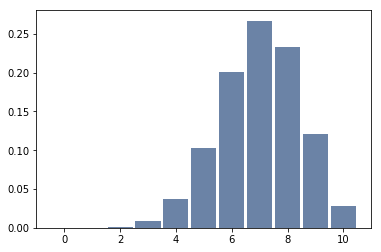

In [45]:
willshow = Pmf({1: P_SHOW, 0: 1-P_SHOW})

prior = sum([willshow] * N_PLAYERS)

thinkplot.Hist(prior)

### Expected rolls

We will treat the provided data as consisting of three separate observations: 
- The lowest stat of all `n` players is 5
- Given that, the highest stat of all `n` players is 16
- Given those things, the lowest and highest stat do not belong to the same player.

First, we will create functions that calculate the probabilities of each observation for an arbitrary group size `n`

In [46]:
def PmfMax(pmf, n):
    return Pmf(Cdf(pmf).Max(n))

def PmfMin(pmf, n):
    # Negates, takes the max, then negates again.
    # This can be done slightly more efficiently by multiplying (1-CDF) directly
    return Pmf([0]) - Pmf(Cdf(Pmf([0]) - pmf).Max(n))

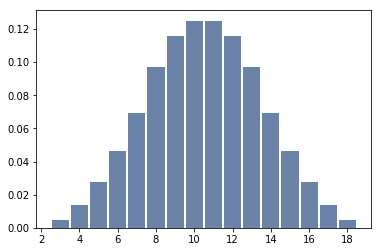

In [47]:
dice = Pmf([1,2,3,4,5,6])
stat = sum([dice]*3)
thinkplot.Hist(stat)

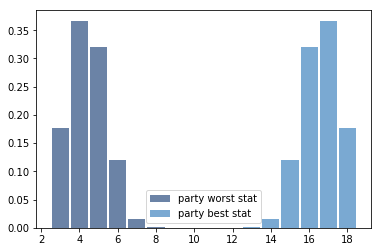

In [48]:
def worst_stat_pmf(n):
    """Computes the distribution of expected worst stats in the party,
    based on the number of members"""
    return PmfMin(stat, n*N_ATTRS)

def best_stat_pmf(n):
    """Computes the distribution of expected best stats in the party,
    based on the number of members"""
    return PmfMax(stat, n*N_ATTRS)

thinkplot.Hist(worst_stat_pmf(7), label='party worst stat')
thinkplot.Hist(best_stat_pmf(7), label='party best stat')

thinkplot.Config()

In [60]:
def p_noncollide(n):
    """
    Computes the probability that the best and worst stats will be from different players.
    Here we interpret "worst stat player" to be the unique person whom both has a valid worst stat
    and also chooses to raise their hand first, and "best stat player" similarly. We assume that
    hand-raising-speed is not correlated between the two questions.
    """
    
    if n < 2:
        return 0
    
    return (n-1)/n
#     return 6*(n-1)/(6*(n-1)+5)

### Update

Update the probabilities by applying Bayes rule.

6.890238682045795


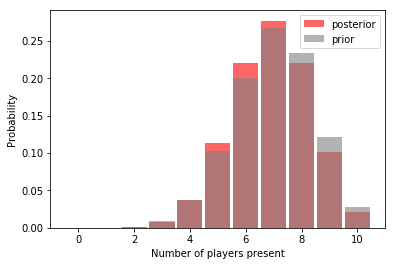

In [62]:
party = prior.Copy()

for n in party:
    worst = worst_stat_pmf(n)
    best = best_stat_pmf(n)
    
    party[n] *= worst[MIN_STAT]
    party[n] *= best[MAX_STAT]
#     party[n] *= p_noncollide(n)
    
party.Normalize()

print(party.Mean())

thinkplot.Hist(party, color='red', label='posterior')
thinkplot.Hist(prior, color='gray', label='prior')
thinkplot.Config(xlabel='Number of players present', ylabel='Probability')

### Remaining issues

This analysis assumes that draws from the "minimum stat" distribution and the "maximum stat" distribution can be done independently. That is, in reality, not quite true as demonstrated by the example below, which compares the distribution of expected max rolls from three d4 dice, 

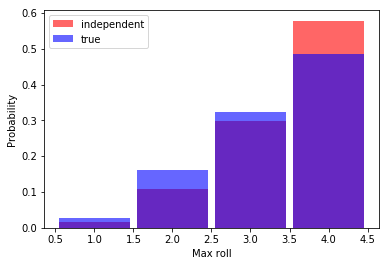

In [10]:
# Demonstration of joint variance of min and max values
import itertools

d4 = Pmf([1,2,3,4])

d4_3 = Pmf(itertools.product([1,2,3,4], repeat=3))

thinkplot.Hist(PmfMax(d4, 3), label='independent', color='red')

d4_3_max = Pmf()
for rolls, p in d4_3.Items():
    if min(rolls) == 1:
        d4_3_max.Incr(max(rolls), p)
        
d4_3_max.Normalize()

thinkplot.Hist(d4_3_max, label='true', color='blue')

thinkplot.Config(xlabel='Max roll', ylabel='Probability')

# The Cat Allergy Problem

### Problem statement

...
party, 10 guest, 4 allergic, 50% of allergic sneeze, 10% of non-allergic sneeze, dist of total guests to sneeze

In [11]:
def coin(p):
    return Pmf({1: p, 0: 1-p})

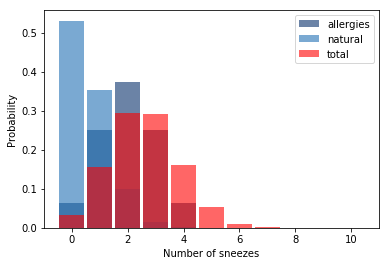

In [12]:
allergic_sneezes = sum([coin(0.5)] * 4)
non_allergic_sneezes = sum([coin(0.1)] * 6)

sneezes = allergic_sneezes + non_allergic_sneezes

thinkplot.Hist(allergic_sneezes, label='allergies')
thinkplot.Hist(non_allergic_sneezes, label='natural')
thinkplot.Hist(sneezes, color='red', label='total')

thinkplot.Config(xlabel='Number of sneezes', ylabel='Probability')

# The Gluten Problem

### Problem description
A few years ago this study showed that many subjects diagnosed with non-celiac gluten sensitivity (NCGS) were not able to distinguish gluten flour from non-gluten flour in a blind challenge.

Here is a description of the study:

    We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.
    
    The gluten-containing flour was correctly identiﬁed by 12 participants (34%)...

Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

Use the data from this study to estimate the number of patients who are actually sensitive to gluten.

To answer this question, you need some additional information, and you have to make some modelling assumptions:

1) Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple you can follow the authors of the study and lump together the second two groups; that is, consider two groups: those who identified the gluten flour and those who did not.

2) Let's assume that people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).


In [13]:
N_SUBJECTS = 35
EXPERIMENTAL_CORRECT = 12
SENSITIVE_ACCURACY = 0.95
RANDOM_ACCURACY = 0.4;

### Prior

Because we were given no other information, we will begin by assuming it is equally likely that anywhere from 0 to 35 participants are truly gluten sensitive.

### Likelihood

Just like the cat problem above, we will create a distribution for how many people we expect to report the gluten correctly for a specified population pool. This will be the sum of two binomial distributions, one for sensitive subjects, and one for non-sensitive subjects guessing at random.

In [14]:
class Gluten(Suite):
    def __init__(self, n_subjects):
        self.n_subjects = n_subjects
        super().__init__(range(n_subjects+1))
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: How many people correctly reported the gluten-containing flour
        hypo: How many people are truly sensitive
        """
        
        sensitive_corrects = MakeBinomialPmf(n=hypo, p=SENSITIVE_ACCURACY)
        random_corrects = MakeBinomialPmf(n=self.n_subjects - hypo, p=RANDOM_ACCURACY)
        
        total_corrects = sensitive_corrects + random_corrects
        
        return total_corrects[data]

In [15]:
prior = Gluten(N_SUBJECTS);

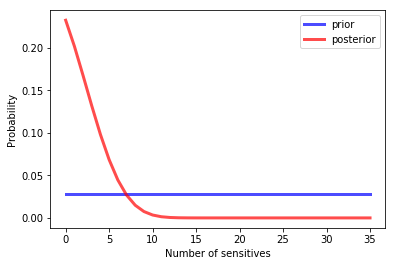

In [16]:
experiment = prior.Copy()
experiment.Update(EXPERIMENTAL_CORRECT)

thinkplot.Plot(prior, color='blue', label='prior')
thinkplot.Plot(experiment, color='red', label='posterior')
thinkplot.Config(xlabel='Number of sensitives', ylabel='Probability')

### Conclusion

The maximum likelihood hypothesis is that nobody in the group has any ability to distinguish gluten-containing from gluten-free flour. This is suspicious, and I suspect something weird is going on.

# The Height Problem

In [17]:
from ipywidgets import interact

1) For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.  Suppose you learn that someone is 170 cm tall.  What is the probability that they are male?  
2) Run this analysis again for a range of observed heights from 150 cm to 200 cm, and plot a curve that shows P(male) versus height.  What is the mathematical form of this function?

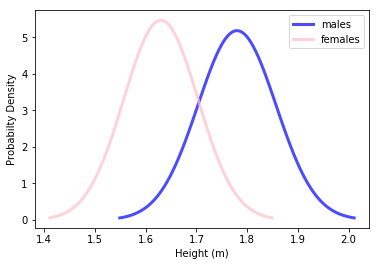

In [18]:
pop_stats = {
    'm': NormalPdf(1.78, .077),
    'f': NormalPdf(1.63, .073)
};
thinkplot.Pdf(pop_stats['m'], color='blue', label='males')
thinkplot.Pdf(pop_stats['f'], color='pink', label='females')

thinkplot.Config(xlabel='Height (m)', ylabel='Probabilty Density')

In [19]:
class HeightProblem(Suite):
    def __init__(self):
        super().__init__('m f'.split())
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: 'm' or 'f'
        hypo: height (cm)
        """
        dist = pop_stats[hypo]
        
        return dist.Density(data)

No handles with labels found to put in legend.


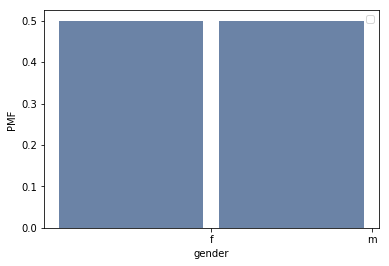

In [20]:
prior = HeightProblem()
thinkplot.Hist(prior)
thinkplot.Config(xlabel='gender', ylabel='PMF')

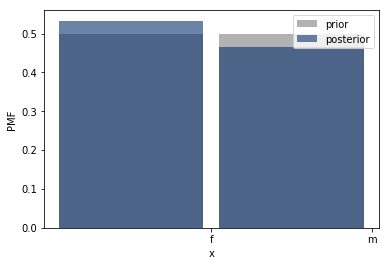

In [21]:
def plot(height = 1.70):
    posterior = prior.Copy()
    posterior.Update(height)
    thinkplot.Hist(prior, color='gray', label='prior')
    thinkplot.Hist(posterior, label='posterior')
    thinkplot.Config(xlabel='x', ylabel='PMF')

plot(1.70)

In [22]:
interact(plot);

interactive(children=(FloatSlider(value=1.7, description='height', max=5.1, min=-1.7), Output()), _dom_classes…

In [23]:
def pmale(height=1.70):
    posterior = prior.Copy()
    posterior.Update(height)
    return posterior['m']

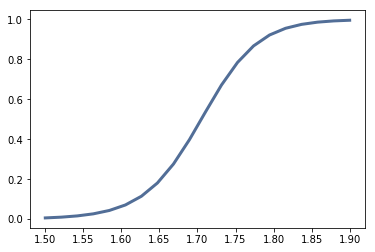

In [24]:
xticks = np.linspace(1.5, 1.9, 20)
thinkplot.Plot(xticks, list(map(pmale, xticks)))

This looks suspiciously similar to the CDF associated with a normal distribution. This derives from the fact that many operations on normal distributions result in other normal distributions, so it should be possible to perform this calculation entirely analytically on a representation with mean and variance.

# The Reddit Problem

This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

### Attempt 1

This model treats both redditors and links as being good or bad, and interprets the "goodness" of a redditor to be a question about our internal confidence they are actually good.

In [25]:
class Redditor(Pmf):
    def __init__(self, score = 0.7):
        super().__init__({'good':score, 'bad':1-score})
        
    def score(self):
        return self['good']
        
class Link(Pmf):
    def __init__(self, score = 0.7):
        super().__init__({'good':score, 'bad':1-score})
        
    def score(self):
        return self['good']

In [26]:
def update_reddit(redditor, link):
    old_redditor = redditor.Copy()
    
    # Good redditors always vote for good links and never for bad links
    redditor['good'] *= link['good']
    # Bad redditors always vote for bad links, and never for good links
    redditor['bad'] *= link['bad']

    link['good'] *= old_redditor['good']
    link['bad'] *= old_redditor['bad']
    
    return redditor.Normalize() * link.Normalize()
    

In [27]:
redditor = Redditor(0.7)
link = Link(0.7)

update_reddit(redditor, link)

redditor, link

(Redditor({'good': 0.8448275862068965, 'bad': 0.1551724137931035}),
 Link({'good': 0.8448275862068965, 'bad': 0.1551724137931035}))

# Reddit 2
The last attempt assumed that every Redditor, and every link, is under the hood either "good" or "bad"

This treatment is more nuanced, and treats the "score" as an underlying true probability that is itself the quantity we are trying to estimate.

A "perfect redditor" is interpreted to mean one that votes "yes" to a link with exactly the frequency corresponding to its true score.

A "perfect link" is interpreted to mean one that gets "yes" votes from redditors in exact correspondance to their own scores.

In other words, a redditor votes by asking a link whether it is good, to which query the link will either tell the truth or lie. The redditor may then themselves choose to lie about what they heard.

In [28]:
# TODO(eric) A normal distribution is kind of stupid here, because we only have a valid 
# domain of 0...1
# TODO(eric) I suspect these can use symbolic distributions throughout and perform all of the updates
# more efficiently
class Redditor2(Pmf):
    def __init__(self, dist=NormalPdf(0.7, 0.5), n=100):
        """The prior here indicates that starting off redditors are better than random at voting."""
        ticks = np.linspace(0, 1, 50)
        super().__init__({p: dist.Density(p) for p in ticks})
        
    def vote_chance(self, theirscore):
        """How likely is this person to vote for a link with the provided score?"""
        # Law of total probability
        return sum([p*(theirscore*myscore + (1-theirscore)*(1-myscore)) for myscore, p in self.Items()])
        
class Link2(Pmf):
    def __init__(self, dist=NormalPdf(0.5, 100.0), n=100):
        """Links are not assumed by default to be any good."""
        ticks = np.linspace(0, 1, 50)
        super().__init__({p: dist.Density(p) for p in ticks})
        
    def vote_chance(self, theirscore):
        """How likely is someone with the hypothesized score to vote for this link?"""
        # Law of total probability
        return sum([p*(theirscore*myscore + (1-theirscore)*(1-myscore)) for myscore, p in self.Items()])
        

In [29]:
# TODO(eric): This algorithm is quadratic in the resolution of the PMF's, there should be a way to do it faster.
def update_reddit_2(r2, l2, vote):
    redditor_copy = r2.Copy()
    
    for s in r2:
        # Update the probability of the redditor having each possible score
        # based on the likelihood of voting for this link if they did
        
        # How likely is someone with the hypothesized score to vote for this link?
        if vote:
            p_vote = l2.vote_chance(s)
        else:
            p_vote = l2.vote_chance(1 - s)
        r2[s] *= p_vote
    
    r2.Normalize()
    
    for s in l2:
        
        if vote:
            p_vote = redditor_copy.vote_chance(s)
        else:
            p_vote = redditor_copy.vote_chance(1-s)
        l2[s] *= p_vote
    
    l2.Normalize()

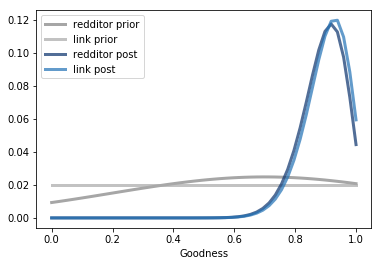

In [30]:
r2 = Redditor2()
l2 = Link2()

thinkplot.Plot(r2, label='redditor prior', color='grey')
thinkplot.Plot(l2, label='link prior', color='darkgrey')

for _ in range(40):
    # The redditor votes "yes" 80% of the time
    update_reddit_2(r2, l2, np.random.random() < 0.80)

thinkplot.Plot(r2, label='redditor post')
thinkplot.Plot(l2, label='link post')

thinkplot.Config(xlabel='Goodness')